## Preliminaries
Import packages

In [11]:
import keras_tuner as kt
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [12]:
genomic_file = "../../Data/MSK_Genomic_Data.csv"

gene_features = pd.read_csv(genomic_file)
#Patient IDs have a space at the end of the name
gene_features['ScoutID'] = gene_features['ScoutID'].str.strip()
# Fixing columns with illegal characters in name
gene_features.rename(columns={'CDKN2A.DEL':'CDKN2A_DEL', 'TGF-Beta_Pathway':'TGF_Beta_Pathway'}, inplace=True)

In [13]:
labels_file = "../../Data/RFS_Scout.xlsx"

rfs_labels = pd.read_excel(labels_file)

In [14]:
rfs_labels.head()

,ScoutID,RFS_Code,RFS
0,Erasmus_ICC-003,0,46.457124
1,Erasmus_ICC-005,1,7.425255
2,Erasmus_ICC-006,1,31.278064
3,Erasmus_ICC-011,1,22.735735
4,Erasmus_ICC-015,1,21.355821


In [15]:
# Getting intersection of patients with gene features and RFS labels all in one dataframe
genes_and_labels = pd.merge(gene_features, rfs_labels, how='inner', on=['ScoutID', 'ScoutID'])

In [16]:
genes_and_labels

,ScoutID,BRAF,IDH1,IDH12,KRAS,TERT,ARID1A,BAP1,CDKN2A_DEL,FGFR2,...,TP53,Epigenetic_Pathway,RTK_RAS_Pathway,TP53_Pathway,Cell_Cycle_Pathway,PI3K_Pathway,DDR_Pathway,TGF_Beta_Pathway,RFS_Code,RFS
0,Erasmus_ICC-003,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,46.457124
1,Erasmus_ICC-005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7.425255
2,Erasmus_ICC-006,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,31.278064
3,Erasmus_ICC-015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,21.355821
4,Erasmus_ICC-020,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,42.580221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,ICC_Radiogen_Add54,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,2.000000
107,ICC_Radiogen_Add9,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,4.000000
108,ICC_Radiogenomics_2,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,0,1,0,0,4.700000
109,ICC_Radiogenomics_3,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6.800000


In [103]:
train_file = "../../Data/train_gene_pats.xlsx"
train_pats = pd.read_excel(train_file)
train_pats.head

<bound method NDFrame.head of                ScoutID
0    047_ICCrecurrence
1    132_ICCrecurrence
2   ICC_Radiogen_Add12
3    127_ICCrecurrence
4    210_ICCrecurrence
..                 ...
94   053_ICCrecurrence
95   160_ICCrecurrence
96   155_ICCrecurrence
97   162_ICCrecurrence
98   088_ICCrecurrence

[99 rows x 1 columns]>

In [104]:
train_gal = pd.merge(train_pats, genes_and_labels, how='inner', on=['ScoutID', 'ScoutID'])
train_gal.head

<bound method NDFrame.head of                ScoutID  BRAF  IDH1  IDH12  KRAS  TERT  ARID1A  BAP1  \
0    047_ICCrecurrence     0     0      0     0     0       0     0   
1    132_ICCrecurrence     0     0      0     0     0       0     0   
2   ICC_Radiogen_Add12     0     0      0     0     0       0     1   
3    127_ICCrecurrence     0     0      0     1     0       0     0   
4    210_ICCrecurrence     0     0      0     0     0       0     0   
..                 ...   ...   ...    ...   ...   ...     ...   ...   
94   053_ICCrecurrence     0     0      0     0     0       0     0   
95   160_ICCrecurrence     0     0      0     0     0       0     1   
96   155_ICCrecurrence     0     1      1     0     0       1     0   
97   162_ICCrecurrence     0     0      0     0     1       0     0   
98   088_ICCrecurrence     0     0      0     0     0       0     0   

    CDKN2A_DEL  FGFR2  ...  TP53  Epigenetic_Pathway  RTK_RAS_Pathway  \
0            1      0  ...     0            

In [ ]:
# from lifelines import CoxPHFitter
# from lifelines.datasets import load_rossi

# rossi = load_rossi()
# cph = CoxPHFitter()
# cph.fit(rossi, duration_col='week', event_col='arrest')
# cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)

# cph.print_summary()

In [157]:
gene = 'TGF_Beta_Pathway'

Text(0.5, 1.0, 'Censoring pattern for TGF_Beta_Pathway')

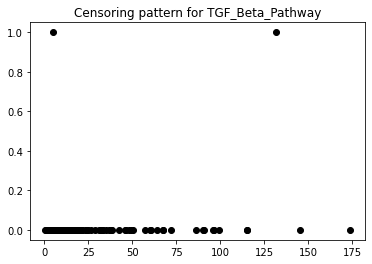

In [158]:
# x-axis is RFS
# y-axis is epigenetic_pathway binary indicator

plt.plot(train_gal.RFS, train_gal[gene], 'o', color='black')
title = "Censoring pattern for " + gene
plt.title(title)

Text(0.5, 1.0, 'Recurrence Free Survival for Cell_Cycle_Pathway Mutations')

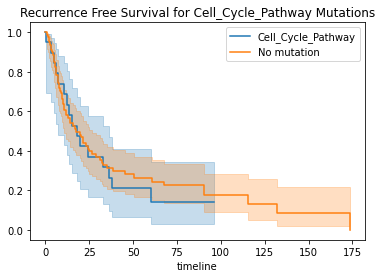

In [150]:
epi_path = train_gal.loc[genes_and_labels[gene] == 1]
non_epi = train_gal.loc[genes_and_labels[gene] == 0]

kmf = KaplanMeierFitter()
ax = plt.subplot(111)

kmf.fit(epi_path.RFS, epi_path.RFS_Code, label=gene)
kmf.plot_survival_function(ax=ax)

kmf.fit(non_epi.RFS, non_epi.RFS_Code, label="No mutation")
kmf.plot_survival_function(ax=ax)

title = "Recurrence Free Survival for " + gene + " Mutations"

plt.title(title)


In [160]:
genes_for_cph = train_gal[["IDH1", "IDH12", "ARID1A", "PBRM1", "RTK_RAS_Pathway", "TP53_Pathway", "Cell_Cycle_Pathway", "RFS", "RFS_Code"]]

cph = CoxPHFitter()
cph.fit(genes_for_cph, duration_col='RFS', event_col='RFS_Code')
cph.print_summary(model="Selected ICC genes", decimals=3)
cph.check_assumptions(genes_for_cph, p_value_threshold=0.05, show_plots=True)

<lifelines.CoxPHFitter: fitted with 99 total observations, 22 right-censored observations>
             duration col = 'RFS'
                event col = 'RFS_Code'
      baseline estimation = breslow
   number of observations = 99
number of events observed = 77
   partial log-likelihood = -288.125
         time fit was run = 2021-11-19 16:41:47 UTC
                    model = Selected ICC genes

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
IDH1               -0.085      0.919      0.781           -1.616            1.447                0.199                4.248
IDH12              -0.240      0.787      0.751           -1.712            1.232                0.181                3.428
ARID1A             -0.222      0.801      0.324           -0.858            0.414                0.424                1.513
PBRM1              -0.356      0.701      0.303           -0.950            0.238                0.387                1.269
RTK_RAS_Pathway     0.244      1.276      0.270           -0.285            0.773                0.752                2.166
TP53_Pathway        0.286      1.331      0.292           -0.287            0.859                0.751                2.362
Cell_Cycle_Pathway  0.122      1.130      0.283           -0.433            0.677                0.648                1.968

                        z     p   -log2(p)
covariate                                 
IDH1               -0.108 0.914      0.130
IDH12              -0.319 0.749      0.416
ARID1A             -0.684 0.494      1.018
PBRM1              -1.174 0.241      2.056
RTK_RAS_Pathway     0.903 0.366      1.449
TP53_Pathway        0.979 0.328      1.610
Cell_Cycle_Pathway  0.430 0.667      0.584
---
Concordance = 0.592
Partial AIC = 590.250
log-likelihood ratio test = 8.529 on 7 df
-log2(p) of ll-ratio test = 1.794

Proportional hazard assumption looks okay.


/home/katy/anaconda3/envs/deepicc/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

In [7]:
import deepsurvk
from deepsurvk import deepsurvk

**X**  - covariates
**Y** - time
**E** - event indicator

In [9]:
genes_and_labels.head

<bound method NDFrame.head of                  ScoutID  BRAF  IDH1  IDH12  KRAS  TERT  ARID1A  BAP1  \
0           001_ICCradio     0     1      1     1     0       1     0   
1      001_ICCrecurrence     0     0      0     1     0       0     0   
2           007_ICCradio     0     0      0     0     0       0     0   
3      007_ICCrecurrence     0     0      0     0     0       0     0   
4           008_ICCradio     0     0      0     0     1       0     0   
..                   ...   ...   ...    ...   ...   ...     ...   ...   
106    ICC_Radiogen_Add9     0     0      0     0     0       0     0   
107  ICC_Radiogenomics_1     0     0      0     0     0       0     0   
108  ICC_Radiogenomics_2     0     0      0     0     0       0     0   
109  ICC_Radiogenomics_3     0     1      1     0     0       0     0   
110  ICC_Radiogenomics_5     0     0      0     0     0       0     1   

     CDKN2A_DEL  FGFR2  ...  TP53  Epigenetic_Pathway  RTK_RAS_Pathway  \
0             0    

In [39]:
X = genes_and_labels.drop(columns={'ScoutID', 'RFS'})
X = X.to_numpy()

Y = genes_and_labels.RFS

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

E_train = X_train[:,-1]
E_test = X_test[:,-1]

X_train = np.delete(X_train, -1, 1)
X_test = np.delete(X_test, -1, 1)

In [40]:
n_patients_train = X_train.shape[0]
n_features = X_train.shape[1]

In [41]:
dsk = deepsurvk.DeepSurvK(n_features=n_features)

loss = deepsurvk.negative_log_likelihood(E_train)
dsk.compile(loss=loss)

In [42]:
callbacks = deepsurvk.common_callbacks()

In [43]:
print(X_train.shape)
print(Y_train.shape)

(88, 18)
(88,)


In [50]:
epochs = 500
history = dsk.fit(X_train, Y_train,
                 batch_size = n_patients_train,
                 epochs = epochs,
                 shuffle = False)

Epoch 1/500
1/1 [==============================] - 0s 2ms/step - loss: 20691.7715
Epoch 2/500
1/1 [==============================] - 0s 2ms/step - loss: 20771.5098
Epoch 3/500
1/1 [==============================] - 0s 2ms/step - loss: 20669.9844
Epoch 4/500
1/1 [==============================] - 0s 2ms/step - loss: 20837.8066
Epoch 5/500
1/1 [==============================] - 0s 2ms/step - loss: 20701.1484
Epoch 6/500
1/1 [==============================] - 0s 2ms/step - loss: 20362.7988
Epoch 7/500
1/1 [==============================] - 0s 1ms/step - loss: 20451.0215
Epoch 8/500
1/1 [==============================] - 0s 2ms/step - loss: 20738.8184
Epoch 9/500
1/1 [==============================] - 0s 2ms/step - loss: 20678.5059
Epoch 10/500
1/1 [==============================] - 0s 1ms/step - loss: 20361.9395
Epoch 11/500
1/1 [==============================] - 0s 1ms/step - loss: 20484.0840
Epoch 12/500
1/1 [==============================] - 0s 2ms/step - loss: 20777.7715
Epoch 13/500


Text(0, 0.5, 'Loss [u.a.]')

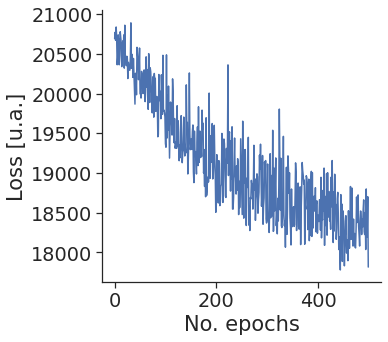

In [51]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plt.plot(history.history['loss'], label='train')
ax.set_xlabel("No. epochs")
ax.set_ylabel("Loss [u.a.]")

In [52]:
Y_pred_train = np.exp(-dsk.predict(X_train))
c_index_train = deepsurvk.concordance_index(Y_train, Y_pred_train, E_train)
print(f"c-index of training dataset = {c_index_train}")

Y_pred_test = np.exp(-dsk.predict(X_test))
c_index_test = deepsurvk.concordance_index(Y_test, Y_pred_test, E_test)
print(f"c-index of testing dataset = {c_index_test}")

c-index of training dataset = 0.6032007179180376
c-index of testing dataset = 0.5299539170506913
